In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('names.txt','r').read().splitlines()

# index all char 
chars = sorted(list(set(''.join(words)))) # make sorted list for all Alphabet in word dataset.
stoi  = {c:i+1 for i,c in enumerate(chars)} 
# hoin['<S>'] = 26
# choin['<E>'] = 27
stoi['.'] = 0

itos = {i+1:c for i,c in enumerate(chars)} 
# inoch[26] = '<S>'
# inoch[27] = '<E>'
itos[0] = '.'
vocab_size = len(itos) # 27


In [3]:
block_size = 3  
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [5]:
batch_size = 32
n  = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [6]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.8176, grad_fn=<NegBackward0>)

In [7]:
hpreact.shape , bngain.shape , bnraw.shape , bnbias.shape

(torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([1, 200]))

In [8]:
def cmp(s,dt,t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)

dlogprobs = torch.zeros_like(logprobs) # loss = -(a+b+c)/3 -> dloss/da = -1/3
dlogprobs[range(n), Yb] = - 1 / n

dprobs = (1 / probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(axis=1,keepdim=True) # (a1*b1 a2*b1 a3*b1) becase we use replication of b1 We need to sum it is all gradient.
# probs = counts * counts_sum_inv -> 32,27 = 32,27 @ 32,1

dcounts = (dprobs * counts_sum_inv)

dcounts_sum = -(counts_sum ** -2) * dcounts_sum_inv

dcounts += torch.ones_like(counts) *  dcounts_sum  # (1 * global_derivative) but we need to be same shape (32, 27) 
# b1 = (a11 + a12 + a13) 
# b2 = (a21 + a22 + a23) -> dbi = 1 
# b3 = (a31 + a32 + a33)

dnorm_logits = (norm_logits.exp()) * dcounts

dlogits = 1 * dnorm_logits

dlogit_maxes = (-1 * dnorm_logits).sum(axis=1,keepdim=True)

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dW2 = h.T @ dlogits
dh =  dlogits @ W2.T
db2 = dlogits.sum(0,keepdim=True)

dhpreact = (1.0 - (h ** 2)) * dh

dbngain = (bnraw * dhpreact).sum(0,keepdim=True)

dbnraw = bngain * dhpreact

dbnbias = dhpreact.sum(0,keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)

dbnvar = (-0.5 * (bnvar+ 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1) )*torch.ones_like(bndiff2) * dbnvar

dbndiff+=( 2 * bndiff) * dbndiff2

dbnmeani = (-1 *  dbndiff).sum(0,keepdim=True)

dhprebn = (1) * dbndiff
dhprebn+= (1.0/n)*torch.ones_like(hprebn) * dbnmeani

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix= Xb[k,j]
        dC[ix] += demb[k, j]
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

Notes:

- Add is Gradient Distributor
- Max is Gradient Router
- Mul is Gradient Switcher
- Local Gradient \* Global Gradient
- Any Node Distributor in Two branches We need to add this their gradient
- Shape of A == Shape of dA
- Sum or Reduction in forwordpass -> Replication or Broadcasting in Backwardpass
- Replication or Broadcasting in forwordpass -> Sum or Reduction in Backwardpass


In [10]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.817564010620117 diff: -2.384185791015625e-07


In [11]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits,1 )
dlogits[range(n),Yb] -=1
dlogits /= n

# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [12]:
Yb[0]

tensor(1)

In [13]:
F.softmax(logits,1)[0]

tensor([0.0126, 0.1952, 0.0169, 0.0305, 0.0625, 0.0165, 0.0105, 0.0131, 0.0277,
        0.0245, 0.0672, 0.0077, 0.0221, 0.0053, 0.0221, 0.0252, 0.0284, 0.0066,
        0.0027, 0.0167, 0.1369, 0.0434, 0.0747, 0.0162, 0.0051, 0.0537, 0.0561],
       grad_fn=<SelectBackward0>)

In [14]:
((dlogits) * n)[0]

tensor([ 0.0126, -0.8048,  0.0169,  0.0305,  0.0625,  0.0165,  0.0105,  0.0131,
         0.0277,  0.0245,  0.0672,  0.0077,  0.0221,  0.0053,  0.0221,  0.0252,
         0.0284,  0.0066,  0.0027,  0.0167,  0.1369,  0.0434,  0.0747,  0.0162,
         0.0051,  0.0537,  0.0561], grad_fn=<SelectBackward0>)

In [15]:
# All the gradient for each logits same except the right one
F.softmax(logits,1)[0][8],((dlogits) * n)[0][8]

(tensor(0.0277, grad_fn=<SelectBackward0>),
 tensor(0.0277, grad_fn=<SelectBackward0>))

In [16]:
# try:
#     plt.figure(figsize=(8,8))
#     plt.imshow(dlogits.detach(),cmap='gray')
#     plt.show()
# except SystemError:   
#     print('')

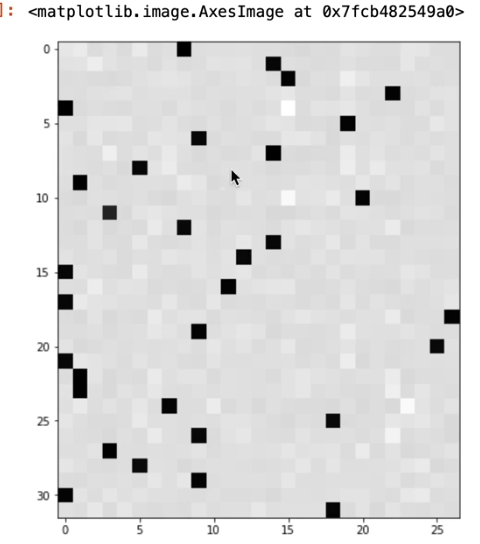


In [17]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [18]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn =   ((bngain * bnvar_inv)/n) * ((n*dhpreact - dhpreact.sum(0)) - (n/(n-1))*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [19]:
C.shape

torch.Size([27, 10])

In [25]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  # loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
 

  dlogits = F.softmax(logits,1 )
  dlogits[range(n),Yb] -=1
  dlogits /= n

  dlogprobs = torch.zeros_like(logprobs) # loss = -(a+b+c)/3 -> dloss/da = -1/3
  dlogprobs[range(n), Yb] = - 1 / n

  dprobs = (1 / probs) * dlogprobs

  dcounts_sum_inv = (counts * dprobs).sum(axis=1,keepdim=True) # (a1*b1 a2*b1 a3*b1) becase we use replication of b1 We need to sum it is all gradient.
  # probs = counts * counts_sum_inv -> 32,27 = 32,27 @ 32,1

  dcounts = (dprobs * counts_sum_inv)

  dcounts_sum = -(counts_sum ** -2) * dcounts_sum_inv

  dcounts += torch.ones_like(counts) *  dcounts_sum  # (1 * global_derivative) but we need to be same shape (32, 27) 
  # b1 = (a11 + a12 + a13) 
  # b2 = (a21 + a22 + a23) -> dbi = 1 
  # b3 = (a31 + a32 + a33)

  dnorm_logits = (norm_logits.exp()) * dcounts
  dlogit_maxes = (-1 * dnorm_logits).sum(axis=1,keepdim=True)
  
  dW2 = h.T @ dlogits
  dh =  dlogits @ W2.T
  db2 = dlogits.sum(0,keepdim=False)

  dhpreact = (1.0 - (h ** 2)) * dh

  
  dbngain = (bnraw * dhpreact).sum(0,keepdim=True)

  dbnraw = bngain * dhpreact

  dbnbias = dhpreact.sum(0,keepdim=True)

  dbndiff = bnvar_inv * dbnraw
  dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)

  dbnvar = (-0.5 * (bnvar+ 1e-5) ** -1.5) * dbnvar_inv
  dbndiff2 = (1.0/(n-1) )*torch.ones_like(bndiff2) * dbnvar

  dbndiff+=( 2 * bndiff) * dbndiff2

  dbnmeani = (-1 *  dbndiff).sum(0,keepdim=True)

  dhprebn  = ((bngain * bnvar_inv)/n) * ((n*dhpreact - dhpreact.sum(0)) - (n/(n-1))*bnraw*(dhpreact*bnraw).sum(0))
  
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)

  demb = dembcat.view(emb.shape)

  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
          ix= Xb[k,j]
          dC[ix] += demb[k, j]

  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]        
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    
    #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
     p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

 

12297
      0/ 200000: 3.8556
  10000/ 200000: 2.1726
  20000/ 200000: 2.3757
  30000/ 200000: 2.4535
  40000/ 200000: 1.9972
  50000/ 200000: 2.3057
  60000/ 200000: 2.3969
  70000/ 200000: 2.0460
  80000/ 200000: 2.3322
  90000/ 200000: 2.1179
 100000/ 200000: 1.9684
 110000/ 200000: 2.3204
 120000/ 200000: 2.0840
 130000/ 200000: 2.4266
 140000/ 200000: 2.3267
 150000/ 200000: 2.2204
 160000/ 200000: 1.9492
 170000/ 200000: 1.7818
 180000/ 200000: 1.9740
 190000/ 200000: 1.9585


: 

In [21]:
# # useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.3504177331924438e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


In [22]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [23]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.5279698371887207
val 3.524165153503418


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

bthajimyazzdzevwvdhmhtlotewurzjekgrnrzcvqchedieliihehpvppaumdexsvqmaxarseptzsmhvkrfcn.
szdbvrgxhggyesrqjccywtelqqxncpvcfcubzbthd.
rhyqrufmekgylzajqyofsyrmthjzickkyaasqfpubjrlvquhmnt.
rbvwivevoeczpfvpxlfqnxoyofhgzptixjhfcuthxwkhmnjrqmidrqixfvwvwtxwvkha.
ortasjt.
tqzdgsesvsymitbftxvbszivsu.
mxlyrkepavmvhsxavwthd.
qqczekkgkktbpvtudtriwbddihzvyrlq.
cjashpaumniotczpvtfviieijrvovxwt.
wynnblbtxzpowyisogsimwosfzybshkhomwcxthlcjkhu.
jtew.
aowvwipsnvwvkdccbcep.
ccafibsnipjyhtewmtsagzuwzlhordckaplomtpoywftnbuzkdfhvkm.
kconksfupswpmtba.
sj.
aucbpc.
civshavbuhrdtehcmm.
ynwilszadgewemtzglhjbtirjyfwikzbyzldfrasjyfuy.
q.
ccwiwsksrfwvotxseefpjesqqjkfdakdyltrqlmduomvvkcgbgdidhtzt.
